# Exercice 1: Learning a WGAN for synthetic 2-dimensional datasets

<br/><br/><br/><br/>

This practical session contains
- "QUESTION" fields in the text, that you should answer
- blocks of code that you should complete at every region marked with ### ... ###

We advise you to open the notebook on Google Colab.

### Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

# If you don't want to bother with the device, stay on cpu:
# device = torch.device('cpu')

print(device)

cuda


### Target Measure

In the following cell, we define the discrete target measure $\nu$ that will serve as dataset for this practical session.

The variable `xgrid` contains a grid of points that will be useful below to display the discriminators along training.

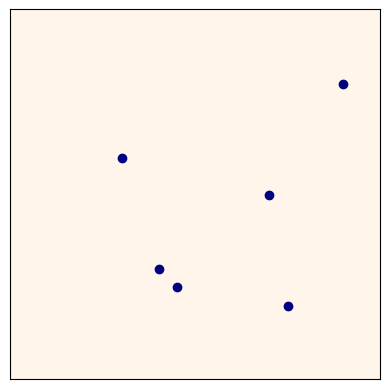

In [ ]:
d = 2   # dimension of the data points

# First dataset with 6 points
n = 6
y = torch.zeros((n,d), device=device)
y[0, 0] = 0.9
y[0, 1] = 0.2
y[1, 0] = 0.75
y[1, 1] = 0.8
y[2, 0] = 0.3
y[2, 1] = 0.4
y[3, 0] = 0.4
y[3, 1] = 0.7
y[4, 0] = 0.45
y[4, 1] = 0.75
y[5, 0] = 0.7
y[5, 1] = 0.5

# # Second dataset with 100 points
# n = 100
# t = torch.pi*torch.linspace(-.2,1.2,n)
# y = .05*torch.randn((n,d))
# y[:,0] += torch.cos(t)
# y[:,1] += torch.sin(2*t)
# y = .5 + .3*y
# y = y.to(device)

# Define masses (empirical measure on the data points)
nu = torch.ones(n, device=device)/n

# generate grid for plotting purpose
nr,nc = 256,256
extent = ((-0.5/nc, 1-0.5/nc, 1-0.5/nr, -0.5/nr))
xs = torch.linspace(0, 1, steps=nr)
ys = torch.linspace(0, 1, steps=nc)
xm, ym = torch.meshgrid(xs, ys, indexing='ij')
xm = xm.T
ym = ym.T
xgrid = torch.cat((xm.reshape(nr*nc,1),ym.reshape(nr*nc,1)),1).to(device)

# Plot data points
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()

## Define Generator architecture

QUESTION: Examine the layers and parameters of the following generative network.

Write a short description of the architecture of this network.

The generator network is defined with the following structure:

- **Input Layer:**
  - Accepts input of dimension `n_in`.

- **Hidden Layers:**
  - Consists of `nlayers` hidden layers.
  - Each hidden layer comprises:
    - A linear transformation: `nn.Linear(n_in_t, n_hid)` where `n_in_t` is `n_in` for the first layer and `n_hid` for subsequent layers.
    - ELU activation function with alpha = 1.0.

- **Output Layer:**
  - Linear transformation: `nn.Linear(n_hid, n_out)`.
  - Sigmoid activation function.

- **Weight Initialization:**
  - Xavier uniform initialization for linear layer weights.
  - Biases initialized to zero.


In [ ]:
class Generator(torch.nn.Module):

    def __init__(self, n_in, n_out, n_hid=10, nlayers=3, device=torch.device("cpu")):
        super(Generator, self).__init__()

        self.n_in = n_in
        self.n_out = n_out
        self.n_hid = n_hid
        self.nlayers = nlayers
        self.hidden = nn.ModuleList()

        for n in range(nlayers):
            n_in_t = n_in if n==0 else n_hid
            self.hidden.append(nn.Sequential(
            nn.Linear(n_in_t, n_hid),
            nn.ELU(1.0)
        ).to(device))

        self.out = nn.Sequential(
            nn.Linear(n_hid, n_out),
            nn.Sigmoid()
        ).to(device)

        self.apply(self._init_weights)


    def forward(self, x):
        for n in range(self.nlayers):
            x = self.hidden[n](x)
        x = self.out(x)
        return x


    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight, 1.0)
            if module.bias is not None:
                module.bias.data.zero_()


QUESTION: Plot one initial configuration of the generator (draw a batch of generated points)

In [ ]:
torch.manual_seed(1)  # initialize random seed for reproducibility

n_in = 10    # dimension of the input noise
b = 100      # batch size

# Initialize generator
G = Generator(n_in=n_in, n_out=d, n_hid=100, nlayers=3, device=device)

# Draw a batch x of generated points
#    Input noise z : standard normal with shape (b, n_in)

### ... ###
z = torch.randn((b,n_in)).to(device)
x = G(z)

x.shape

torch.Size([100, 2])

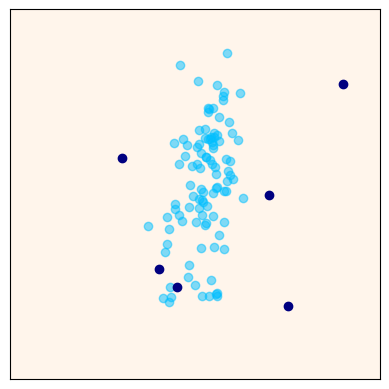

In [ ]:
# Plot
xd = x.detach()
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()

## Define Discriminator Architecture

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, n_in, n_hid=10):
    super(Discriminator, self).__init__()

    self.n_hid = n_hid
    self.n_in = n_in

    self.fc1 = nn.Linear(n_in, n_hid)
    self.fc2 = nn.Linear(n_hid, n_hid)
    self.fc3 = nn.Linear(n_hid, 1)

  def forward(self, x):
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc1(x))
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc2(y))
    y = self.fc3(y)
    return y

## Discriminator training with Weight clipping

QUESTION: For a fixed generator, train the discriminator with WGAN loss and weight clipping.

Try changing the clip_value. What do you observe?

we noitice that training with this method yields poor results. The clip value had a huge effect on the training process. In fact, by reducing the clip value we reduce the training capabilities and we get stuck and this is shown by the curve of the loss (especially for values that are close to 0). whereas big values that are higher than 1 shouldn't be good since we want to get in the end a 1-lipchitz function.

In [ ]:
torch.manual_seed(1)  # initialize random seed for reproducibility

# fix one generator
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)

# parameters for discriminator optimization
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
niterD=1000

clip_value = .1

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

In [ ]:
def Loss_WGAN(D_y,D_g_y) :
  return D_y.mean(axis=0) - D_g_y.mean(axis=0)
x_ =x.detach()

[0/1000], -0.010782


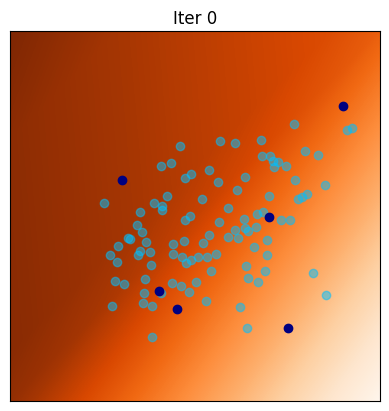

[100/1000], 0.000760


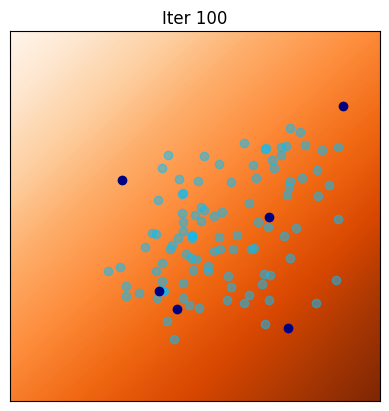

[200/1000], 0.002203


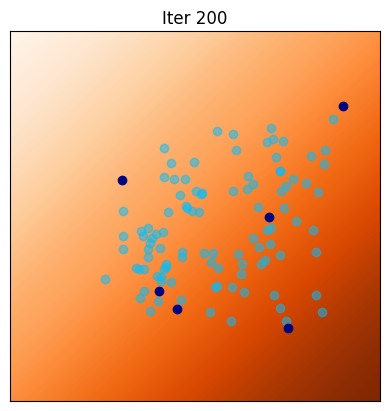

[300/1000], 0.003413


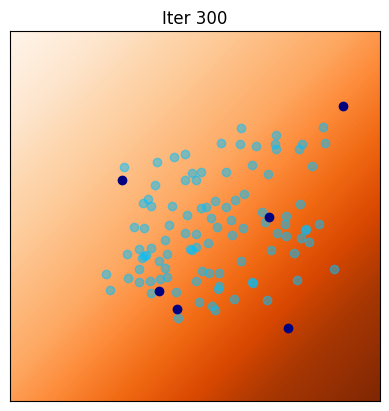

[400/1000], 0.002564


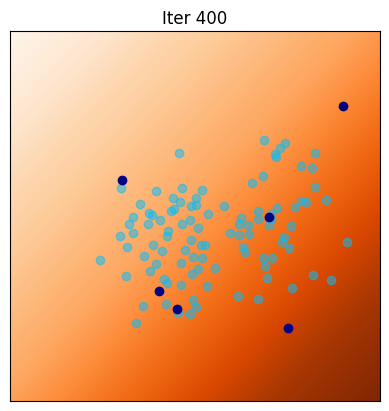

[500/1000], 0.004775


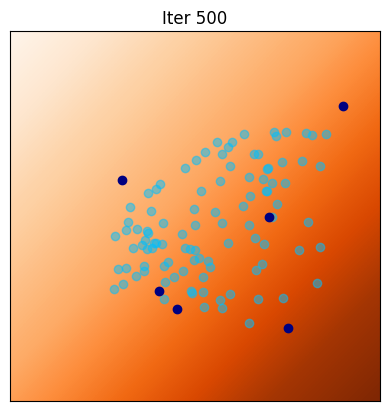

[600/1000], 0.003655


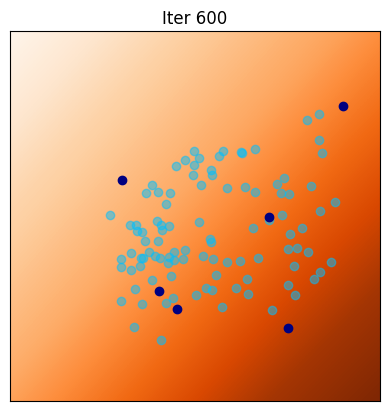

[700/1000], 0.004833


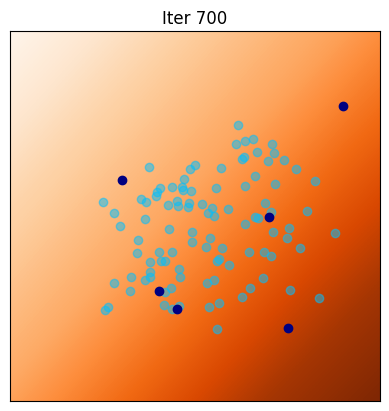

[800/1000], 0.002552


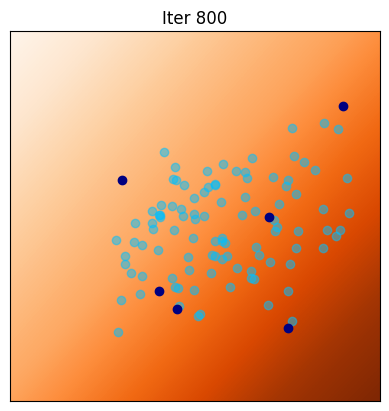

[900/1000], 0.004703


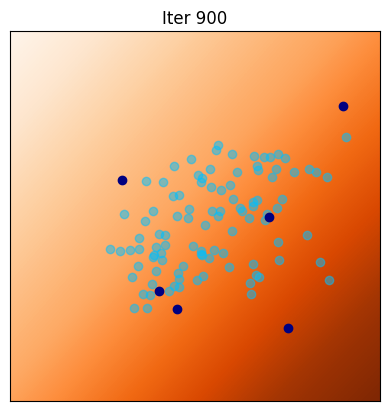

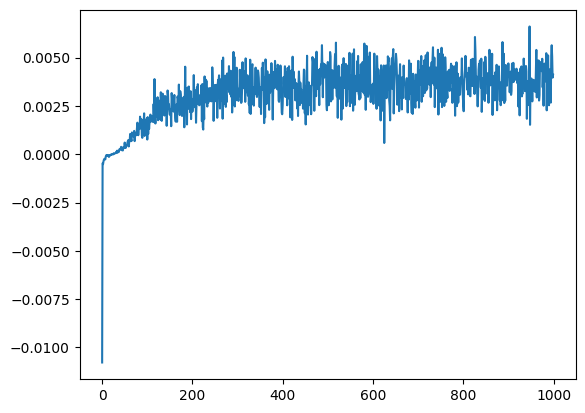

In [ ]:
iter_display = 100  # display current configuration each iter_display iteration

# Lists to keep track of progress
Dlosses = []

for iter in range(0,niterD):

    ### UPDATE OF D ###
    optimD.zero_grad()

    ### ... ###
    D_y = D(y)
    z = torch.randn((b,n_in)).to(device)
    D_g_y = D(G(z))
    Dloss =  -Loss_WGAN(D_y,D_g_y)
    ### ... ###

    Dloss.backward()

    optimD.step()

    ### ... Weight Clipping ... ###
    for p in D.parameters():
      p.data.clamp_(-clip_value,clip_value)

    ### SAVE LOSS ###
    Dlosst = -Dloss.item()
    Dlosses.append(Dlosst)

    if(iter%iter_display == 0):
        print('[%d/%d], %f' % (iter, niterD, Dlosst))
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Iter '+str(iter)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()

plt.plot(Dlosses)

## Estimate the Lipschitz constant of the discriminator

The following function computes a lower bound of the Lipschitz constant of $D$ on points that are interpolated between $x$ and $y$.

NB: If $x$ and $y$ do not have the same number of points, we discard the last points.
In comment, we give an alternative code that allows to compute all segments $[x_i, y_j]$ (but it is, of course, slower that just computing segments $[x_i, y_i]$).

In [ ]:
def lipconstant(D,x,y):
    b = x.shape[0]
    n = y.shape[0]
    # shrink vectors if they are too large
    if n>b:
        y = y[0:b,:]
        n = b
    else:
        x = x[0:n,:]
        b = n
    # compute interpolated points
    alpha = torch.rand((b,1),device=device)
    interp = alpha * y + (1 - alpha) * x
    interp.requires_grad_()

    # Calculate probability of interpolated examples
    Di = D(interp).view(-1)

    # Calculate gradients of probabilities with respect to examples
    gradout = torch.ones(Di.size()).to(device)
    gradients = torch.autograd.grad(outputs=Di, inputs=interp, grad_outputs=gradout,
       create_graph=True, retain_graph=True)[0]

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1))

    # Return gradient penalty
    return torch.mean(gradients_norm)

#     # Calculate interpolation
#     b = x.shape[0]
#     n = y.shape[0]
#     alpha = torch.rand((b,n,1),device=device)
#     interp = (alpha * y[None,:,:] + (1 - alpha) * x[:,None,:]).flatten(end_dim=1)
#     interp.requires_grad_()


QUESTION: Use this function to examine the Lipschitz constant of the final discriminator obtained above with weight clipping.


In [ ]:
### ... ###
x = G(torch.randn((b,n_in)).to(device))
lip_cst = lipconstant(D,x,y)
print(f"lower bound of the lipschitz constant is  {lip_cst :.3f}")

lower bound of the lipschitz constant is  0.072


## Gradient Penalty

QUESTION: Implement a function computing the gradient penalty of a discriminator $D$ on points $X$ that are randomly interpolated between $x$ and $y$:
$$ GP(D) = \mathbb{E}\left[ \Big(\|\nabla D(X)\| - 1 \Big)^2 \right] .$$
In pratice you will use
$$\|\nabla D(X)\| \approx \sqrt{\|\nabla D (X)\|_2^2 + 10^{-12} } $$
to avoid numerical instability.

In [ ]:
def gradient_penalty(D,x,y):
    b = x.shape[0]
    n = y.shape[0]
    # shrink vectors if they are too large
    if n>b:
        y = y[0:b,:]
        n = b
    else:
        x = x[0:n,:]
        b = n
    # compute interpolated points
    alpha = torch.rand((b,1),device=device)
    interp = (alpha * y + (1 - alpha) * x)
    interp.requires_grad_()

#     # Calculate interpolation
#     b = x.shape[0]
#     n = y.shape[0]
#     alpha = torch.rand((b,n,1),device=device)
#     interp = (alpha * y[None,:,:] + (1 - alpha) * x[:,None,:]).flatten(end_dim=1)
#     interp.requires_grad_()

    # Calculate probability of interpolated examples
    Di = D(interp).view(-1)

    # Calculate gradients of probabilities with respect to examples
    gradout = torch.ones(Di.size()).to(device)
    gradients = torch.autograd.grad(outputs=Di, inputs=interp, grad_outputs=gradout,
       create_graph=True, retain_graph=True)[0]

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients**2,dim=1)+1e-12)

    # Return gradient penalty
    return ((gradients_norm - 1) ** 2).mean()
#     return ((gradients_norm - 1) ** 2*(gradients_norm>1)).mean()

print(gradient_penalty(D,x,y))

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


tensor(0.5593, device='cuda:0', grad_fn=<MeanBackward0>)


## Discriminator training with Gradient Penalty

QUESTION: Complete the following code at the blocks ###...###.

Adjust the weight of the gradient penalty (parameter `gpw`) to get a Lipschitz constant $\approx 1$.

In [ ]:
def Loss_WGAN_GP (D_y,D_g_y,GP,lamda):
  return Loss_WGAN(D_y,D_g_y)-lamda*GP

In [ ]:
#z = torch.randn((b,n_in))
#x=G(z).detach()

[0/1000], Dloss=-0.2892, Lip(D)=0.2673


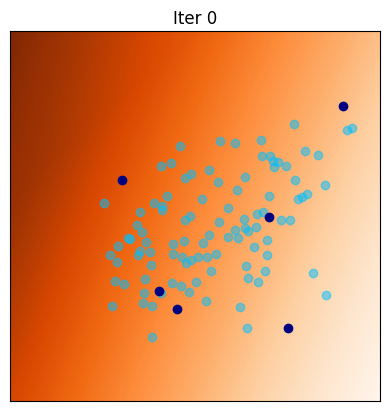

[100/1000], Dloss=-0.0134, Lip(D)=0.9621


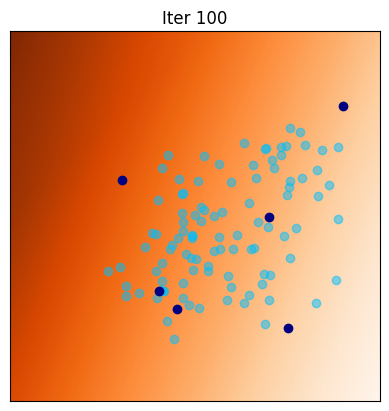

[200/1000], Dloss=-0.0255, Lip(D)=0.9507


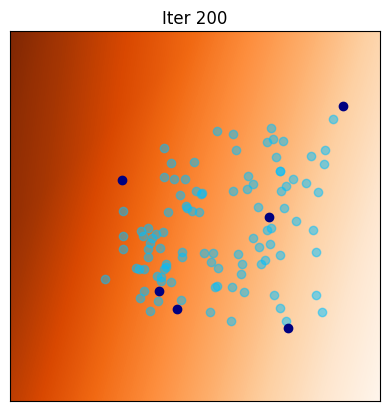

[300/1000], Dloss=-0.0263, Lip(D)=0.9815


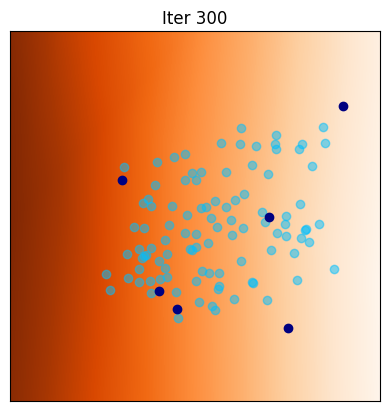

[400/1000], Dloss=-0.0058, Lip(D)=1.0130


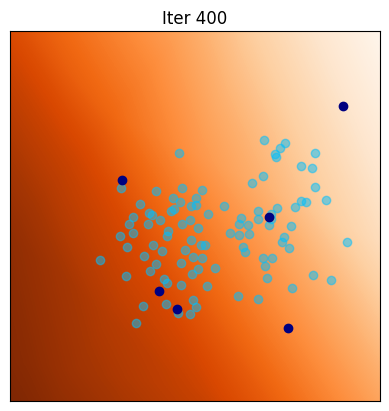

[500/1000], Dloss=0.0505, Lip(D)=0.9628


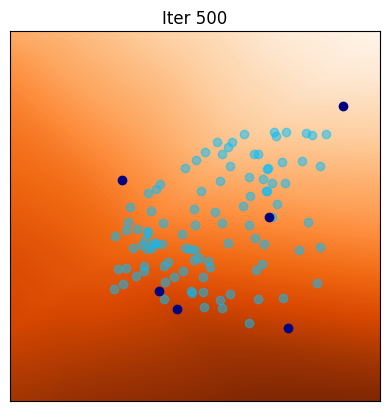

[600/1000], Dloss=0.0816, Lip(D)=1.0113


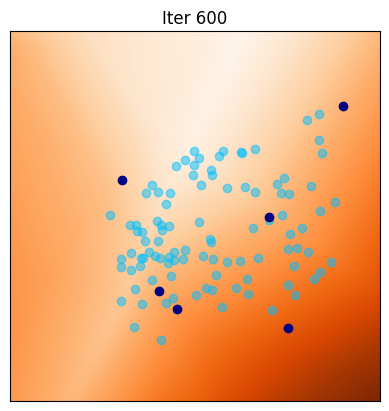

[700/1000], Dloss=0.1333, Lip(D)=1.0461


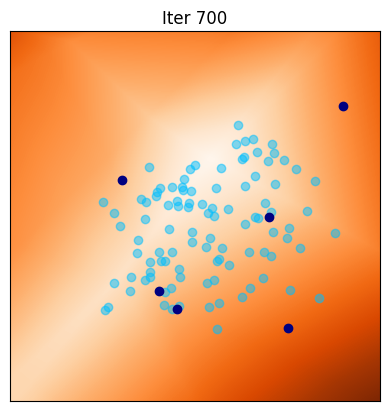

[800/1000], Dloss=0.1213, Lip(D)=1.0697


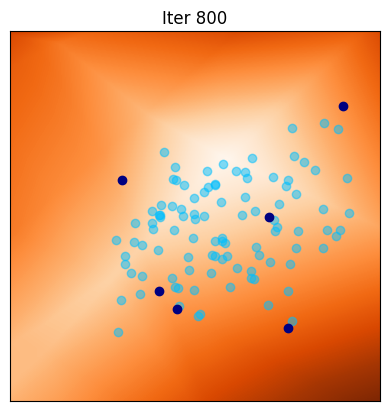

[900/1000], Dloss=0.1466, Lip(D)=1.1387


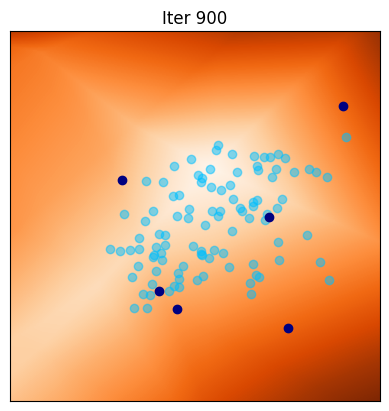

Final estimated Lipschitz constant =  1.1543971300125122


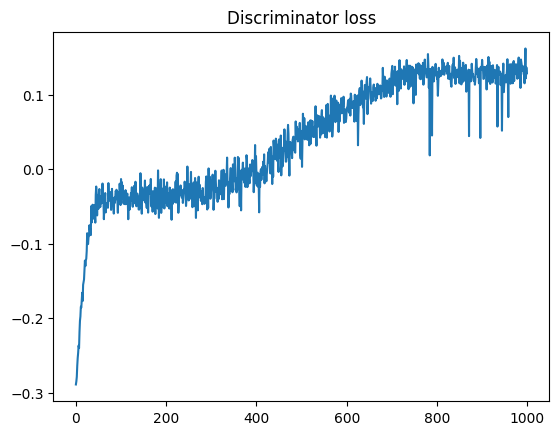

In [ ]:
torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
D = Discriminator(n_in=d, n_hid=10).to(device)

# parameters for training
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
niterD=1000
gpw = .5     # parameter for gradient penalty
lamda = gpw
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))


iter_display = 100  # display current configuration each iter_display iteration

# Lists to keep track of progress
Dlosses = []

for iter in range(0,niterD):

    ### UPDATE OF D ###
    optimD.zero_grad()

    D_y = D(y)
    z = torch.randn((b,n_in)).to(device)
    x = G(z)
    D_g_y = D(x)
    GP =  gradient_penalty(D,x,y)
    Dloss = -Loss_WGAN_GP(D_y,D_g_y,GP,lamda)

    Dloss.backward()
    optimD.step()

    ### ... ###

    ### SAVE LOSS ###
    Dlosst = -Dloss.item()
    Dlosses.append(Dlosst)

    if(iter%iter_display == 0):
        print('[%d/%d], Dloss=%.4f, Lip(D)=%.4f' % (iter, niterD, Dlosst,lipconstant(D,x,y).item()))
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Iter '+str(iter)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()

print('Final estimated Lipschitz constant = ',lipconstant(D,x,y).item())

plt.figure(dpi=100)
plt.plot(Dlosses)
plt.title('Discriminator loss')
plt.show()

In [ ]:
D1 = D

## WGAN-GP training

QUESTION: Complete the following code in order to train simultaneously the generator and discriminator.

You will alternate `niterD` iterations on the discriminator and `niterG` iterations of the discriminator.

[1/100] 	Loss_D: -0.1485	Loss_G: 0.0729	Lip(D)=1.7492
[2/100] 	Loss_D: -0.0914	Loss_G: 0.2641	Lip(D)=1.5943
[3/100] 	Loss_D: -0.1198	Loss_G: 0.2669	Lip(D)=1.6023
[4/100] 	Loss_D: -0.0672	Loss_G: -0.1276	Lip(D)=1.3506
[5/100] 	Loss_D: -0.1092	Loss_G: -0.1401	Lip(D)=1.5280
[6/100] 	Loss_D: -0.1338	Loss_G: 0.2491	Lip(D)=1.4176
[7/100] 	Loss_D: -0.0623	Loss_G: 0.4443	Lip(D)=1.2328
[8/100] 	Loss_D: -0.0947	Loss_G: 0.7062	Lip(D)=1.2904
[9/100] 	Loss_D: -0.0733	Loss_G: 0.4955	Lip(D)=1.2017
[10/100] 	Loss_D: -0.0485	Loss_G: 0.6548	Lip(D)=1.2628


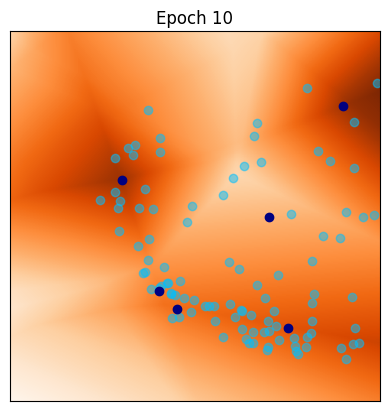

[11/100] 	Loss_D: -0.1469	Loss_G: 0.8772	Lip(D)=1.2188
[12/100] 	Loss_D: -0.0675	Loss_G: 0.5300	Lip(D)=1.1489
[13/100] 	Loss_D: -0.0995	Loss_G: 0.5317	Lip(D)=1.5074
[14/100] 	Loss_D: -0.1009	Loss_G: 0.8366	Lip(D)=1.2024
[15/100] 	Loss_D: -0.1118	Loss_G: 0.6455	Lip(D)=1.3736
[16/100] 	Loss_D: -0.1667	Loss_G: 0.3685	Lip(D)=1.4708
[17/100] 	Loss_D: -0.1249	Loss_G: -0.1027	Lip(D)=1.2357
[18/100] 	Loss_D: -0.1400	Loss_G: -0.1307	Lip(D)=1.3054
[19/100] 	Loss_D: -0.1358	Loss_G: -0.1737	Lip(D)=1.6146
[20/100] 	Loss_D: -0.1223	Loss_G: -0.2761	Lip(D)=1.4796


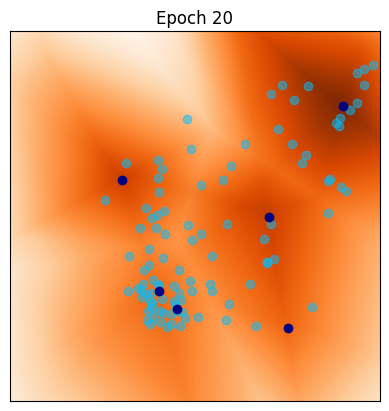

[21/100] 	Loss_D: -0.0881	Loss_G: -0.5555	Lip(D)=1.3139
[22/100] 	Loss_D: -0.1106	Loss_G: -0.6889	Lip(D)=1.5212
[23/100] 	Loss_D: -0.1090	Loss_G: -0.6705	Lip(D)=1.5310
[24/100] 	Loss_D: -0.1187	Loss_G: -0.6212	Lip(D)=1.4383
[25/100] 	Loss_D: -0.1099	Loss_G: -0.9213	Lip(D)=1.2786
[26/100] 	Loss_D: -0.0893	Loss_G: -1.4201	Lip(D)=1.3125
[27/100] 	Loss_D: -0.1377	Loss_G: -1.6063	Lip(D)=1.5151
[28/100] 	Loss_D: -0.1163	Loss_G: -1.5552	Lip(D)=1.6812
[29/100] 	Loss_D: -0.1377	Loss_G: -1.6522	Lip(D)=1.4760
[30/100] 	Loss_D: -0.1049	Loss_G: -1.9556	Lip(D)=1.4173


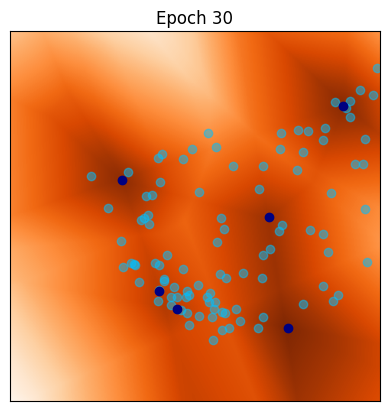

[31/100] 	Loss_D: -0.1061	Loss_G: -2.1088	Lip(D)=1.3995
[32/100] 	Loss_D: -0.1113	Loss_G: -1.9692	Lip(D)=1.3041
[33/100] 	Loss_D: -0.1266	Loss_G: -2.1176	Lip(D)=1.4776
[34/100] 	Loss_D: -0.1151	Loss_G: -2.3606	Lip(D)=1.4875
[35/100] 	Loss_D: -0.1283	Loss_G: -2.7621	Lip(D)=1.6995
[36/100] 	Loss_D: -0.1086	Loss_G: -2.8989	Lip(D)=1.4703
[37/100] 	Loss_D: -0.1024	Loss_G: -2.7725	Lip(D)=1.5247
[38/100] 	Loss_D: -0.1176	Loss_G: -2.9545	Lip(D)=1.5477
[39/100] 	Loss_D: -0.1320	Loss_G: -3.4611	Lip(D)=1.4339
[40/100] 	Loss_D: -0.0971	Loss_G: -3.5684	Lip(D)=1.2026


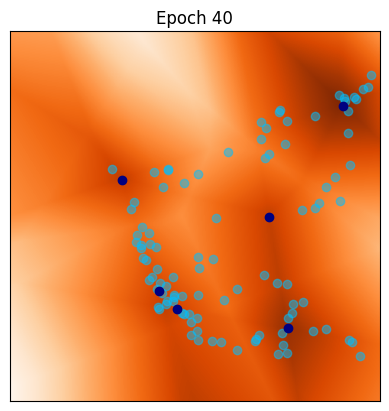

[41/100] 	Loss_D: -0.0931	Loss_G: -3.7557	Lip(D)=1.2278
[42/100] 	Loss_D: -0.0955	Loss_G: -4.0709	Lip(D)=1.3485
[43/100] 	Loss_D: -0.0971	Loss_G: -4.3683	Lip(D)=1.3962
[44/100] 	Loss_D: -0.0987	Loss_G: -4.7925	Lip(D)=1.3616
[45/100] 	Loss_D: -0.1020	Loss_G: -5.1919	Lip(D)=1.2960
[46/100] 	Loss_D: -0.0907	Loss_G: -5.3453	Lip(D)=1.3069
[47/100] 	Loss_D: -0.1030	Loss_G: -5.6940	Lip(D)=1.3401
[48/100] 	Loss_D: -0.0732	Loss_G: -6.4323	Lip(D)=1.3729
[49/100] 	Loss_D: -0.0900	Loss_G: -7.6953	Lip(D)=1.2887
[50/100] 	Loss_D: -0.1088	Loss_G: -7.8540	Lip(D)=1.4081


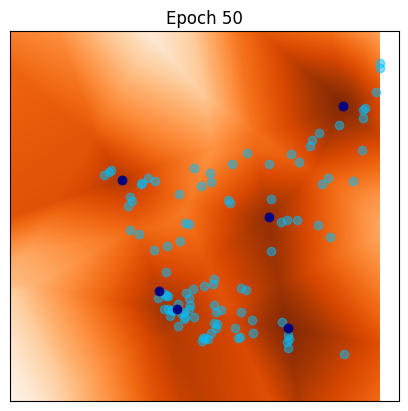

[51/100] 	Loss_D: -0.1183	Loss_G: -7.7530	Lip(D)=1.1549
[52/100] 	Loss_D: -0.0882	Loss_G: -8.0849	Lip(D)=1.3303
[53/100] 	Loss_D: -0.0985	Loss_G: -8.2545	Lip(D)=1.1697
[54/100] 	Loss_D: -0.0587	Loss_G: -8.3757	Lip(D)=1.3115
[55/100] 	Loss_D: -0.0816	Loss_G: -8.3360	Lip(D)=1.3967
[56/100] 	Loss_D: -0.1176	Loss_G: -8.5328	Lip(D)=1.4123
[57/100] 	Loss_D: -0.1005	Loss_G: -9.0156	Lip(D)=1.3694
[58/100] 	Loss_D: -0.1109	Loss_G: -9.4177	Lip(D)=1.3649
[59/100] 	Loss_D: -0.0963	Loss_G: -9.5385	Lip(D)=1.5424
[60/100] 	Loss_D: -0.0810	Loss_G: -9.5963	Lip(D)=1.4289


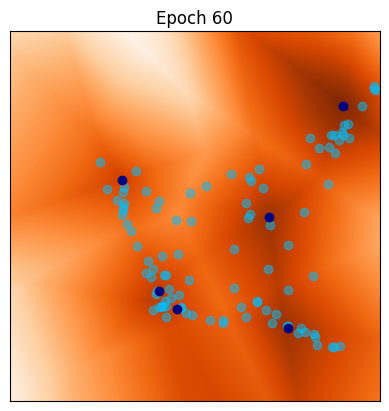

[61/100] 	Loss_D: -0.0836	Loss_G: -9.7065	Lip(D)=1.3686
[62/100] 	Loss_D: -0.0627	Loss_G: -9.8207	Lip(D)=1.3817
[63/100] 	Loss_D: -0.0991	Loss_G: -11.5797	Lip(D)=1.4416
[64/100] 	Loss_D: -0.0890	Loss_G: -11.1520	Lip(D)=1.2051
[65/100] 	Loss_D: -0.0990	Loss_G: -9.9638	Lip(D)=1.4591
[66/100] 	Loss_D: -0.0909	Loss_G: -11.0102	Lip(D)=1.1862
[67/100] 	Loss_D: -0.0837	Loss_G: -11.1933	Lip(D)=1.4865
[68/100] 	Loss_D: -0.1019	Loss_G: -11.4537	Lip(D)=1.2954
[69/100] 	Loss_D: -0.0763	Loss_G: -12.9469	Lip(D)=1.3416
[70/100] 	Loss_D: -0.0926	Loss_G: -12.4873	Lip(D)=1.2344


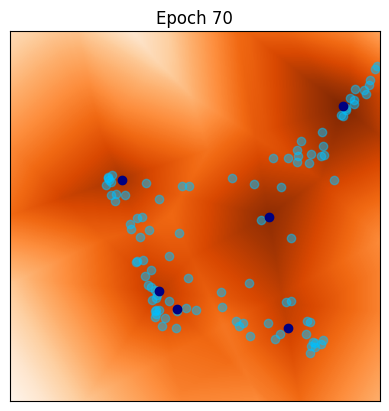

[71/100] 	Loss_D: -0.1019	Loss_G: -13.8392	Lip(D)=1.3838
[72/100] 	Loss_D: -0.1232	Loss_G: -15.5004	Lip(D)=1.5570
[73/100] 	Loss_D: -0.1080	Loss_G: -17.3435	Lip(D)=1.0961
[74/100] 	Loss_D: -0.1110	Loss_G: -16.5981	Lip(D)=1.2608
[75/100] 	Loss_D: -0.1746	Loss_G: -16.8164	Lip(D)=1.5023
[76/100] 	Loss_D: -0.0905	Loss_G: -18.5537	Lip(D)=1.3688
[77/100] 	Loss_D: -0.1245	Loss_G: -21.0910	Lip(D)=1.4959
[78/100] 	Loss_D: -0.0928	Loss_G: -19.6744	Lip(D)=1.2077
[79/100] 	Loss_D: -0.1417	Loss_G: -18.3661	Lip(D)=1.4479
[80/100] 	Loss_D: -0.0960	Loss_G: -20.1074	Lip(D)=1.1695


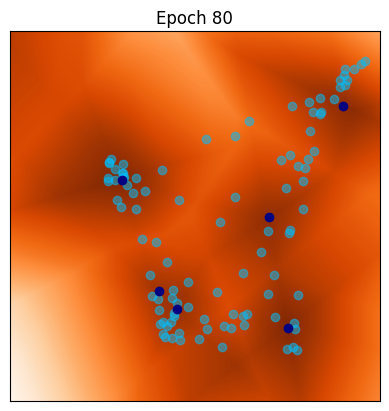

[81/100] 	Loss_D: -0.1145	Loss_G: -22.7600	Lip(D)=1.2531
[82/100] 	Loss_D: -0.0718	Loss_G: -22.1376	Lip(D)=1.1620
[83/100] 	Loss_D: -0.1283	Loss_G: -21.4958	Lip(D)=1.4127
[84/100] 	Loss_D: -0.0689	Loss_G: -24.2912	Lip(D)=1.6439
[85/100] 	Loss_D: -0.1110	Loss_G: -26.0688	Lip(D)=1.2541
[86/100] 	Loss_D: -0.0977	Loss_G: -25.7537	Lip(D)=1.2692
[87/100] 	Loss_D: -0.0817	Loss_G: -23.5400	Lip(D)=1.4652
[88/100] 	Loss_D: -0.0963	Loss_G: -25.0978	Lip(D)=1.4669
[89/100] 	Loss_D: -0.0727	Loss_G: -25.1053	Lip(D)=1.2361
[90/100] 	Loss_D: -0.1018	Loss_G: -25.9714	Lip(D)=1.3390


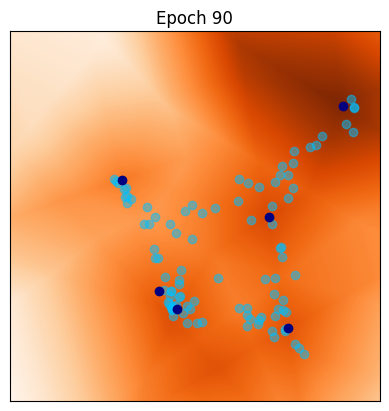

[91/100] 	Loss_D: -0.0945	Loss_G: -27.0304	Lip(D)=1.2216
[92/100] 	Loss_D: -0.0848	Loss_G: -28.2614	Lip(D)=1.3346
[93/100] 	Loss_D: -0.0918	Loss_G: -27.9928	Lip(D)=1.2163
[94/100] 	Loss_D: -0.0964	Loss_G: -25.2980	Lip(D)=1.1603
[95/100] 	Loss_D: -0.0735	Loss_G: -26.4373	Lip(D)=1.2797
[96/100] 	Loss_D: -0.0923	Loss_G: -31.0342	Lip(D)=0.9645
[97/100] 	Loss_D: -0.0809	Loss_G: -28.4113	Lip(D)=1.2560
[98/100] 	Loss_D: -0.0729	Loss_G: -25.9316	Lip(D)=1.0134
[99/100] 	Loss_D: -0.0725	Loss_G: -29.9653	Lip(D)=1.3967


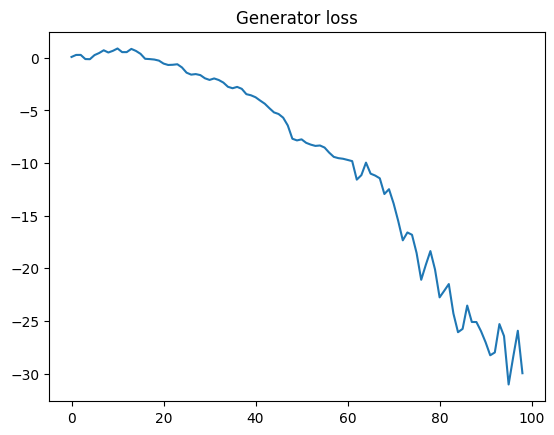

<All keys matched successfully>

In [ ]:
## parameters for training
n_epochs = 100
niterD=1000
niterG=10
gpw = 0.1

lr = 0.002      # learning rate for generator
lrdisc = 0.002  # learning rate for discriminator
beta_1 = 0.05
beta_2 = 0.999

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))


Glosses = []
Dlosses = []

iter_display = 10

# Main loop
for epoch in range(1,n_epochs):

    ############################
    ### Train discriminator (niterD iterations)
    ############################

    for iter in range(0,niterD):
        ###

      ### UPDATE OF D ###
        optimD.zero_grad()

        D_y = D(y)

        z = torch.randn((b,n_in)).to(device)

        x = G(z)
        D_g_y = D(x)

        GP =  gradient_penalty(D,x,y)
        Dloss = -Loss_WGAN_GP(D_y,D_g_y,GP,gpw)

        Dloss.backward()
        optimD.step()

        ### ... ###

    ############################
    ### Train generator (niterG iterations)
    ############################
    for iter in range(0,niterG):
        ### ... ###
        optimG.zero_grad()

        z = torch.randn((b,n_in)).to(device)
        x = G(z)
        D_g_y = D(x)

        Gloss = -D_g_y.mean(axis=0)

        Gloss.backward()
        optimG.step()
        ### ... ###

    # Output training stats
    print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f\tLip(D)=%.4f'
      % (epoch, n_epochs, Dloss.item(), Gloss.item(),lipconstant(D,x,y).item()))
    Glosses.append(Gloss.item())
    Dlosses.append(-Dloss.item())

    if(epoch % iter_display == 0):
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        z = torch.randn(b, n_in, device=device)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Epoch '+str(epoch)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()


plt.figure(dpi=100)
plt.plot(Glosses)
plt.title('Generator loss')
plt.show()

# Save final generator for later use
wgan = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
wgan.load_state_dict(G.state_dict())

## Sensitivy to hyper-parameters

QUESTION: Repeat the WGAN learning experiment, by changing the parameters of the optimization (learning rates, number of updates of D and G, etc).

From your experiments, can you draw a few recommendations for stable training?

Through our experiments with WGAN learning, we found several key insights for stable training:

for stable training, we should opt for learning rates that balance convergence speed and stability. High rates can lead to oscillations, while low rates slow down convergence.

Furthermore, updating the discriminator more frequently than the generator helps maintain stable training dynamics without hindering generator convergence.

In addtion, we should regularly track the Lipschitz constant of the discriminator to gauge stability. Stable Lipschitz values correlate with smoother training.

Besides, Both generator and discriminator losses should converge to stable values over training epochs, indicating effective learning.

Therefore, we need to Choose moderate learning rates, balance updates between discriminator and generator, and monitor Lipschitz constant for stability.

By adhering to these guidelines,we can achieve stable and efficient training of WGAN models, leading to better sample generation and discrimination performance.

'lr': 0.001, 'niterD': 100, 'niterG': 10, 'gpw': 0.1,'beta_1': 0.5,'beta_2': 0.999, 'min Glosses' :-5.056155681610107,'max Dlosses' : 2.552586078643799


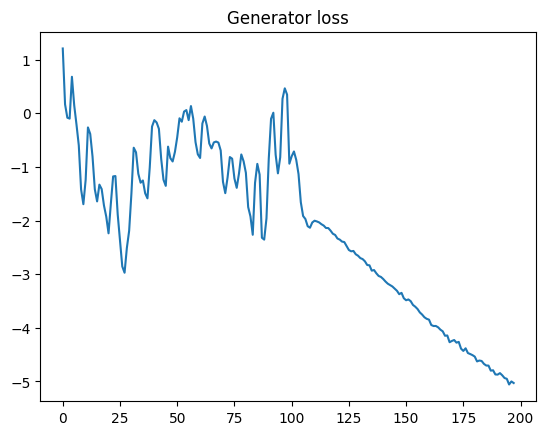

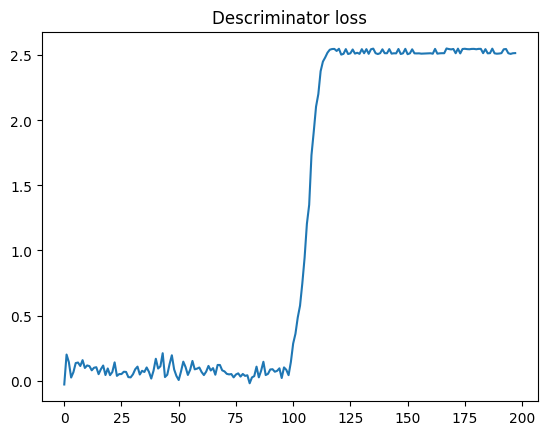

'lr': 0.001, 'niterD': 100, 'niterG': 10, 'gpw': 0.1,'beta_1': 0.9,'beta_2': 0.999, 'min Glosses' :-5.056155681610107,'max Dlosses' : 2.5527234077453613


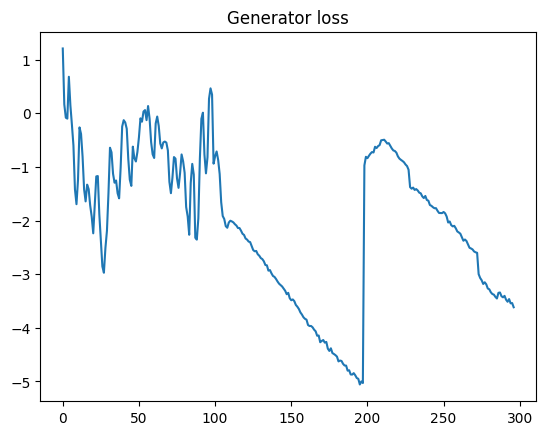

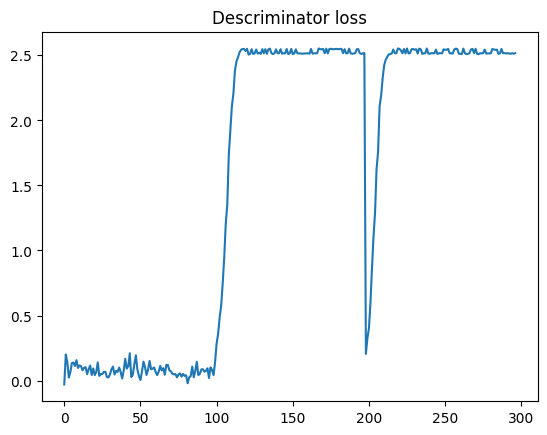

'lr': 0.001, 'niterD': 100, 'niterG': 10, 'gpw': 0.5,'beta_1': 0.5,'beta_2': 0.999, 'min Glosses' :-5.056155681610107,'max Dlosses' : 2.5527234077453613


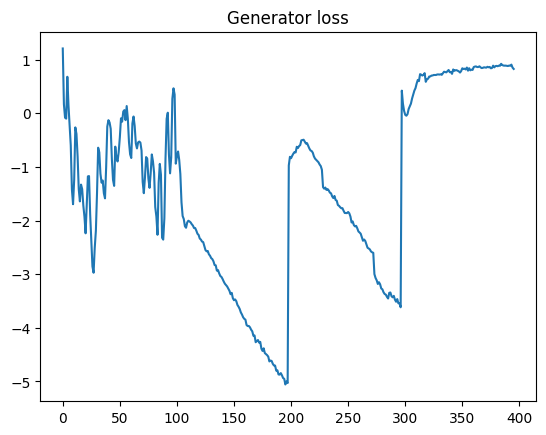

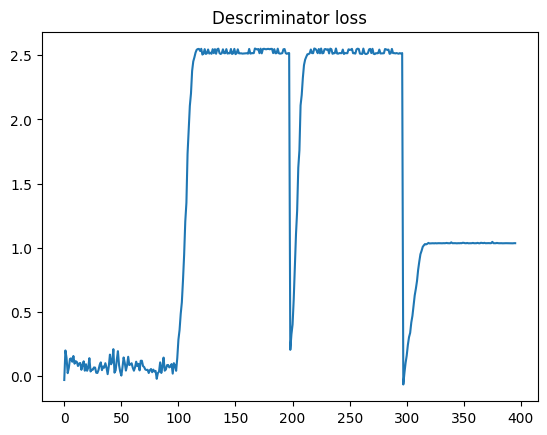

'lr': 0.001, 'niterD': 100, 'niterG': 10, 'gpw': 0.5,'beta_1': 0.9,'beta_2': 0.999, 'min Glosses' :-5.056155681610107,'max Dlosses' : 2.5527234077453613


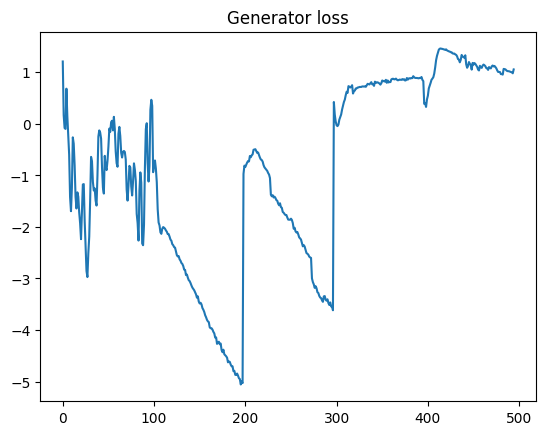

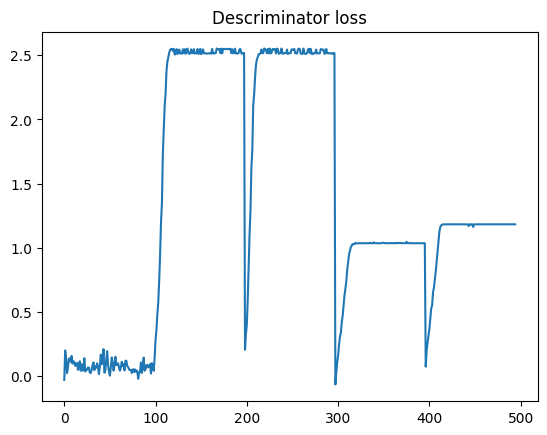

'lr': 0.001, 'niterD': 100, 'niterG': 10, 'gpw': 1.0,'beta_1': 0.5,'beta_2': 0.999, 'min Glosses' :-5.056155681610107,'max Dlosses' : 2.5527234077453613


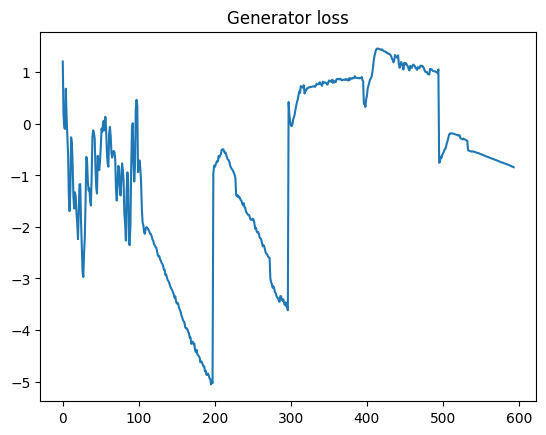

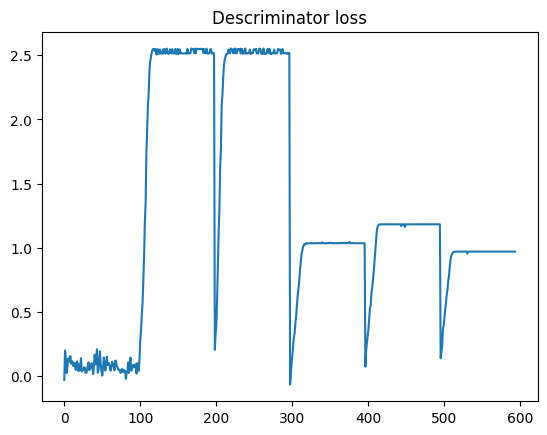

'lr': 0.001, 'niterD': 100, 'niterG': 10, 'gpw': 1.0,'beta_1': 0.9,'beta_2': 0.999, 'min Glosses' :-5.056155681610107,'max Dlosses' : 2.5527234077453613


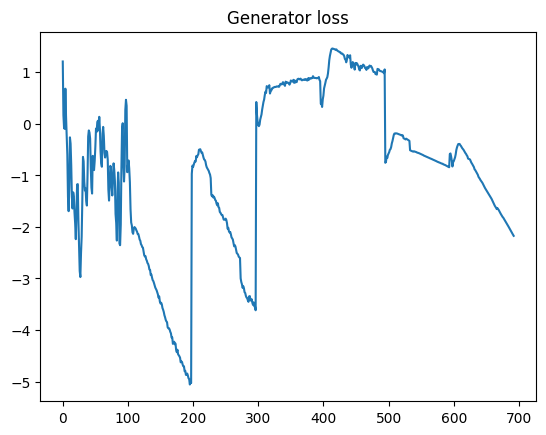

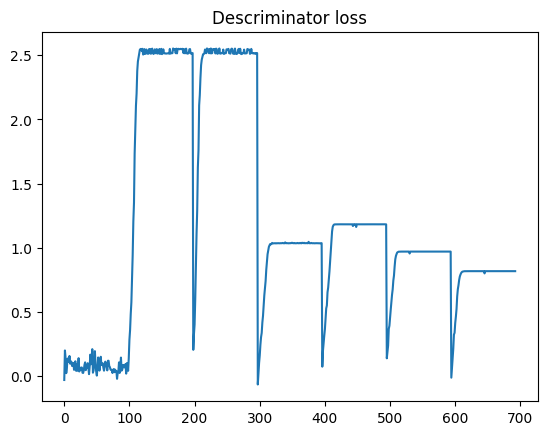

'lr': 0.002, 'niterD': 100, 'niterG': 10, 'gpw': 0.1,'beta_1': 0.5,'beta_2': 0.999, 'min Glosses' :-5.056155681610107,'max Dlosses' : 2.5527234077453613


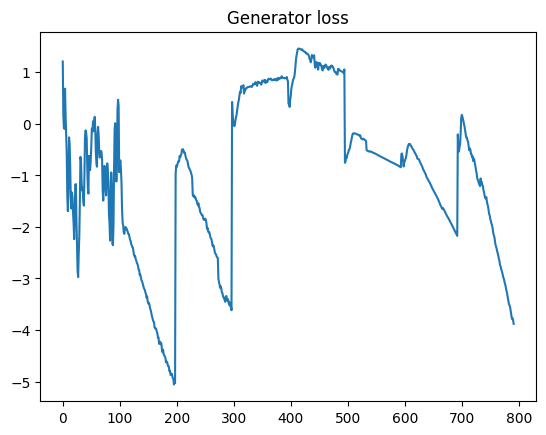

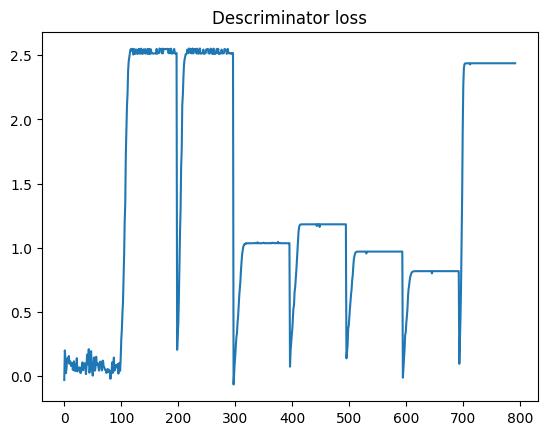

'lr': 0.002, 'niterD': 100, 'niterG': 10, 'gpw': 0.1,'beta_1': 0.9,'beta_2': 0.999, 'min Glosses' :-5.056155681610107,'max Dlosses' : 2.5798332691192627


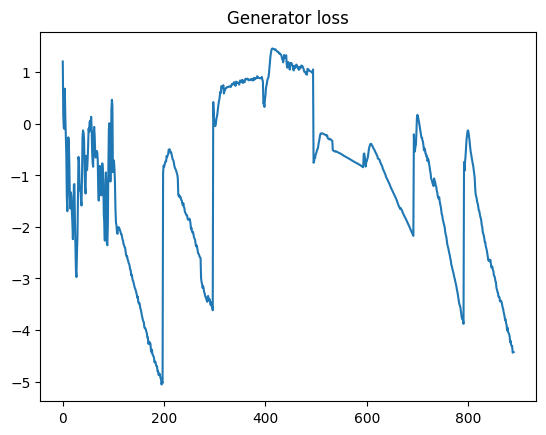

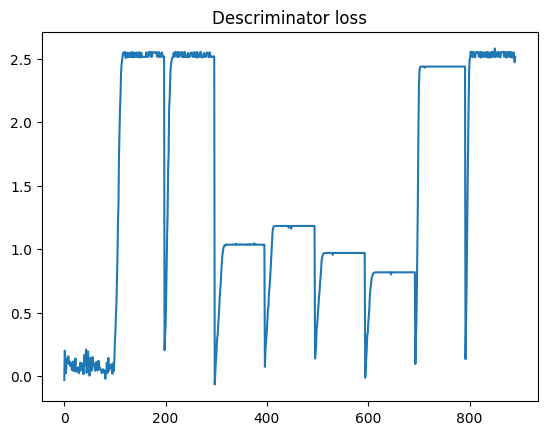

'lr': 0.002, 'niterD': 100, 'niterG': 10, 'gpw': 0.5,'beta_1': 0.5,'beta_2': 0.999, 'min Glosses' :-5.056155681610107,'max Dlosses' : 2.5798332691192627


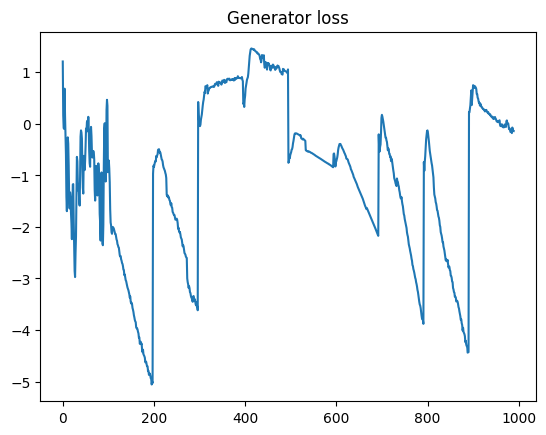

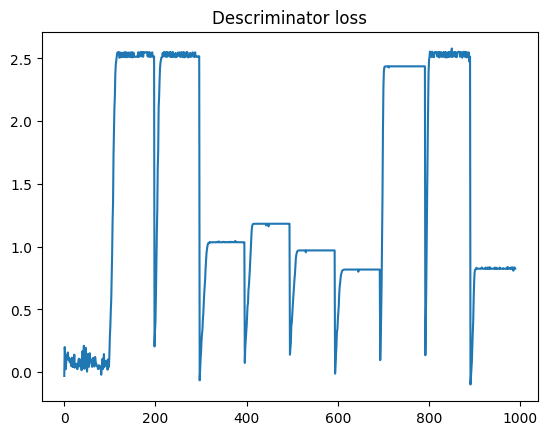

'lr': 0.002, 'niterD': 100, 'niterG': 10, 'gpw': 0.5,'beta_1': 0.9,'beta_2': 0.999, 'min Glosses' :-5.056155681610107,'max Dlosses' : 2.5798332691192627


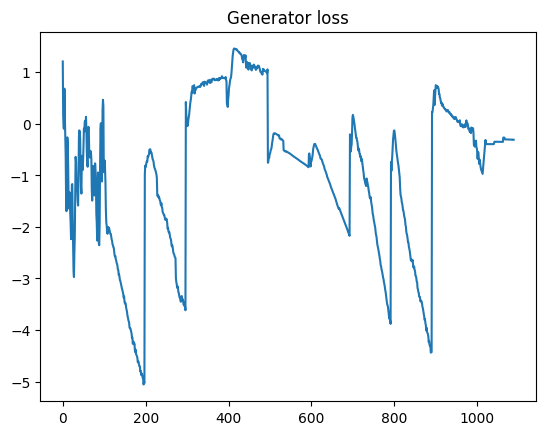

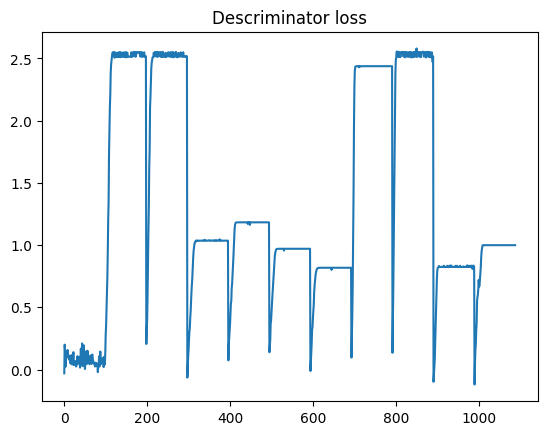

'lr': 0.002, 'niterD': 100, 'niterG': 10, 'gpw': 1.0,'beta_1': 0.5,'beta_2': 0.999, 'min Glosses' :-5.056155681610107,'max Dlosses' : 2.5798332691192627


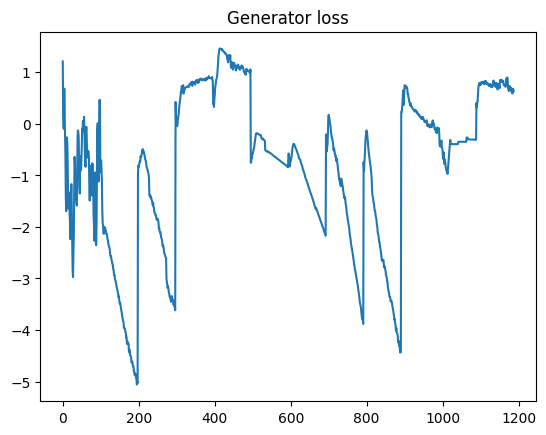

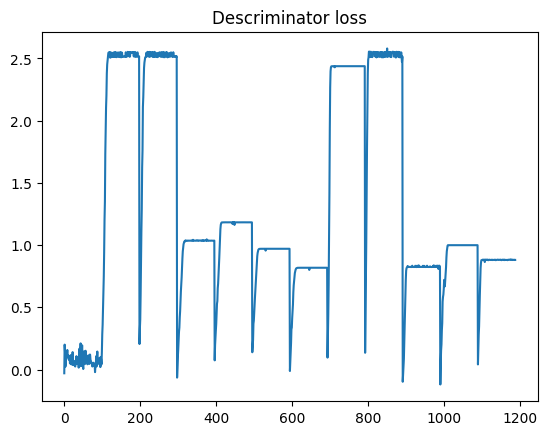

'lr': 0.002, 'niterD': 100, 'niterG': 10, 'gpw': 1.0,'beta_1': 0.9,'beta_2': 0.999, 'min Glosses' :-5.056155681610107,'max Dlosses' : 2.5798332691192627


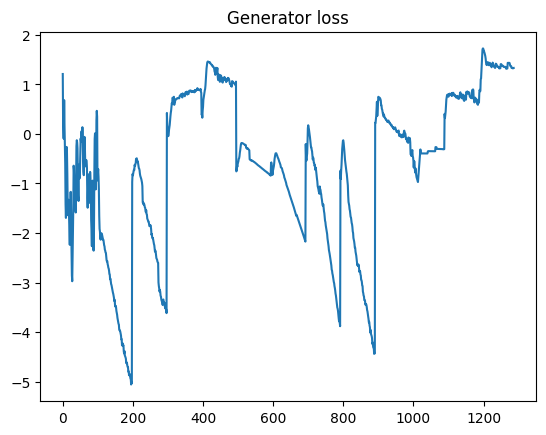

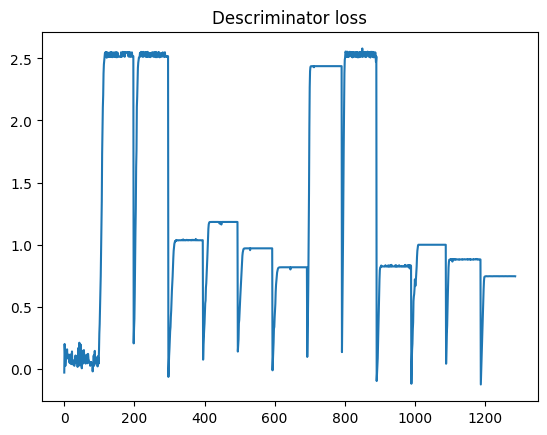

In [ ]:
# Define your training loop with sensitivity analysis here
def sensitivity_analysis():
    # Hyperparameters to tune
    learning_rates = [0.001, 0.002]
    niterD_values = [100]
    niterG_values = [ 10]
    gpw_values = [0.1, 0.5, 1.0]
    beta_1_values = [0.5, 0.9]
    beta_2_values = [0.999]

    results = []

    for lr in learning_rates:
        for niterD in niterD_values:
            for niterG in niterG_values:
                for gpw in gpw_values:
                    for beta_1 in beta_1_values:
                        for beta_2 in beta_2_values:

                            # Initialize generators and discriminators
                            G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
                            optimG = optim.Adam(G.parameters(), lr=lr)

                            D = Discriminator(n_in=d, n_hid=10).to(device)
                            optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

                            # Train WGAN with the current set of hyperparameters
                            # Main loop
                            for epoch in range(1,n_epochs):

                                ############################
                                ### Train discriminator (niterD iterations)
                                ############################

                                for iter in range(0,niterD):
                                    ###

                                  ### UPDATE OF D ###
                                    optimD.zero_grad()

                                    D_y = D(y)
                                    z = torch.randn((b,n_in)).to(device)
                                    x = G(z)
                                    D_g_y = D(x)
                                    GP =  gradient_penalty(D,x,y)
                                    Dloss = -Loss_WGAN_GP(D_y,D_g_y,GP,gpw)

                                    Dloss.backward()
                                    optimD.step()

                                    ### ... ###

                                ############################
                                ### Train generator (niterG iterations)
                                ############################
                                for iter in range(0,niterG):
                                    ### ... ###
                                    optimD.zero_grad()
                                    z = torch.randn((b,n_in)).to(device)
                                    x = G(z)
                                    D_g_y = D(x)
                                    Gloss = -D_g_y.mean(axis=0)

                                    Gloss.backward()
                                    optimG.step()
                                    ### ... ###

                                # Output training stats
                                #print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f\tLip(D)=%.4f'
                                  #% (epoch, n_epochs, Dloss.item(), Gloss.item(),lipconstant(D,x,y).item()))
                                Glosses.append(Gloss.item())
                                Dlosses.append(-Dloss.item())
                            # Compute relevant metrics (e.g., final Lipschitz constant, stability of training)

                            # Store the results along with the hyperparameters used
                            results.append({
                                'lr': lr,
                                'niterD': niterD,
                                'niterG': niterG,
                                'gpw': gpw,
                                'beta_1': beta_1,
                                'beta_2': beta_2,
                                'Glosses' :Glosses,
                                'Dlosses' : Dlosses
                            })

                        print(f"'lr': {lr}, 'niterD': {niterD}, 'niterG': {niterG}, 'gpw': {gpw},'beta_1': {beta_1},'beta_2': {beta_2}, 'min Glosses' :{np.min(Glosses)},'max Dlosses' : {np.max(Dlosses)}")
                        plt.figure(dpi=100)
                        plt.plot(Glosses)
                        plt.title('Generator loss')
                        plt.show()

                        plt.figure(dpi=100)
                        plt.plot(Dlosses)
                        plt.title('Descriminator loss')
                        plt.show()
    return results

# Run sensitivity analysis
analysis_results = sensitivity_analysis()

# Analyze results and draw recommendations based on the performance of different hyperparameter configurations
# You can analyze convergence, sample quality, stability, etc., to draw recommendations



## Train the generator only

QUESTION: For a fixed discriminator, optimize only the generator only. Can you explain what is happening then?

For a fixed discriminator, the learning process enables the generator to learn the patterns of the discriminator and update its weights so that the new points will be generated in the areas where the discriminator thinks its a real image. This is shown in the plots below. The points converges towards the darkest areas.

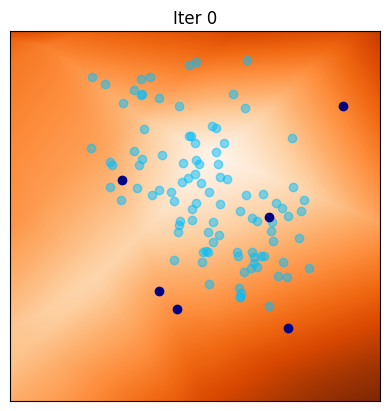

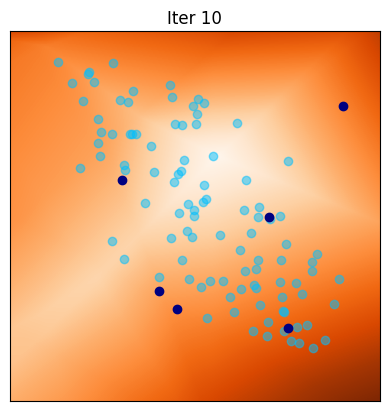

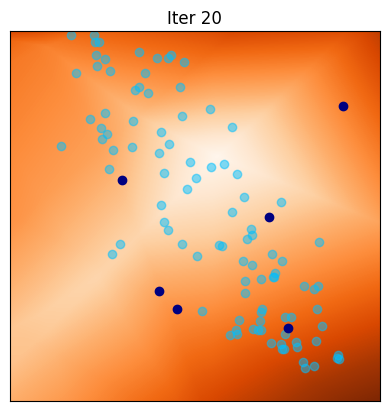

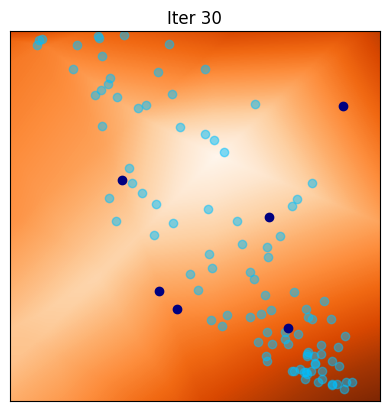

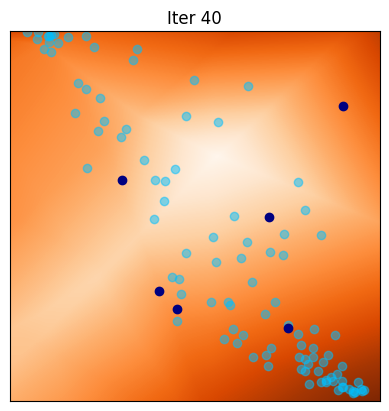

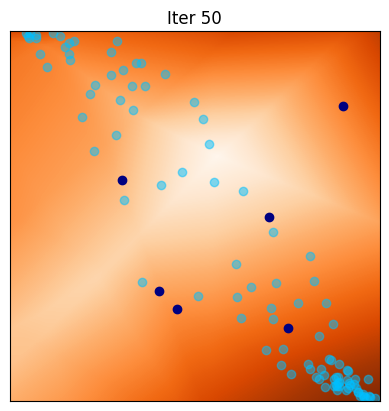

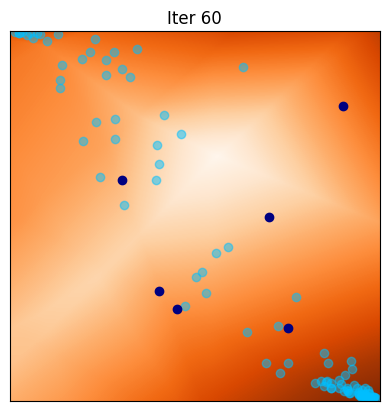

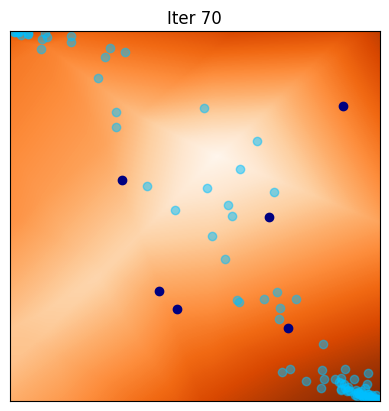

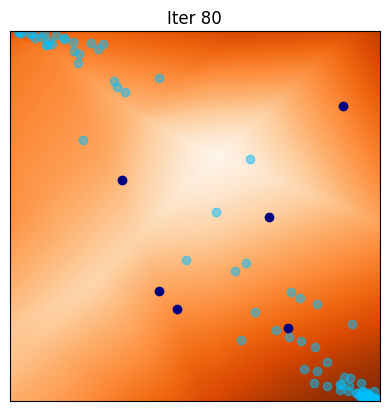

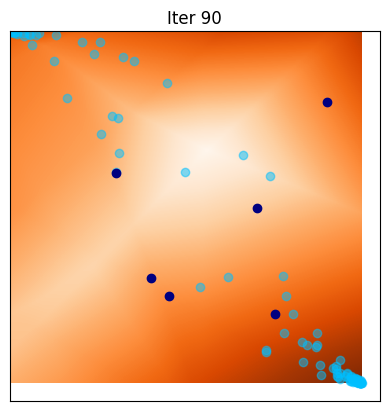

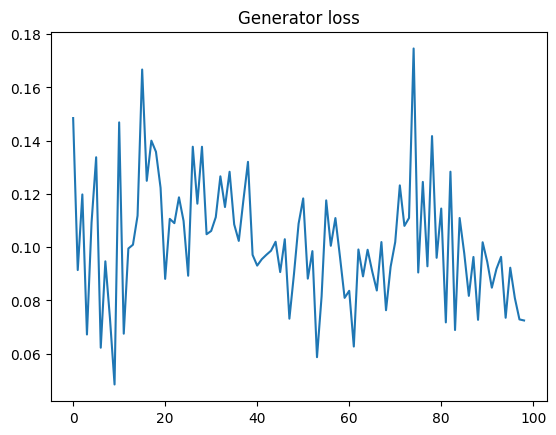

In [ ]:
# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
D=D1
# parameters for training
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
niterG=100
gpw = .1     # parameter for gradient penalty
lamda = gpw
optimG = optim.Adam(G.parameters(), lr=lrdisc, betas=(beta_1, beta_2))


iter_display = 10  # display current configuration each iter_display iteration

# Lists to keep track of progress
Glosses = []

for iter in range(0,niterG):
    if(iter%iter_display == 0):
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Iter '+str(iter)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()
    ### ... ###
    optimG.zero_grad()
    z = torch.randn((b,n_in)).to(device)
    x = G(z)
    D_g_y = D(x)
    Gloss = -D_g_y.mean(axis=0)

    Gloss.backward()
    optimG.step()
    ### ... ###

    ### SAVE LOSS ###
    Glosst = Gloss.item()
    Glosses.append(Glosst)

plt.figure(dpi=100)
plt.plot(Dlosses)
plt.title('Generator loss')
plt.show()

<br/><br/><br/><br/>

# BONUS Exercise (to do at home) : Learn a standard GAN

## Define Loss for GAN training

For stable GAN training uses the Binary cross-entropy loss which takes labeled data as input.

The data points $y$ should correspond to values $\approx 1$, whereas fake points $x$ should get values $\approx 0$.

We also introduce the sigmoid function. for displaying purpose: for GAN training, the discriminator values in $[0,1]$ will be obtained by applying after $D$.

In [ ]:
criterion = nn.BCEWithLogitsLoss()
V1 = torch.full((n,1), 1. , dtype=torch.float, device=device)
V0 = torch.full((b,1), 0. , dtype=torch.float, device=device)

sig = nn.Sigmoid()

## Train the discriminator for a fixed generator

QUESTION: Complete the following code at the blocks ###...###

[0/2000], -1.503897


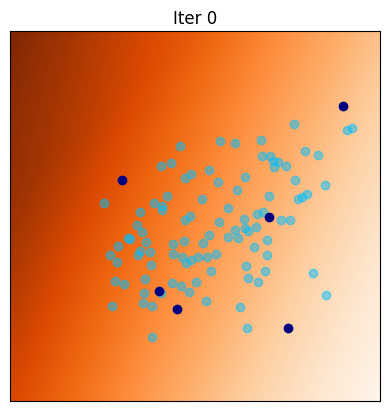

[100/2000], -1.382602


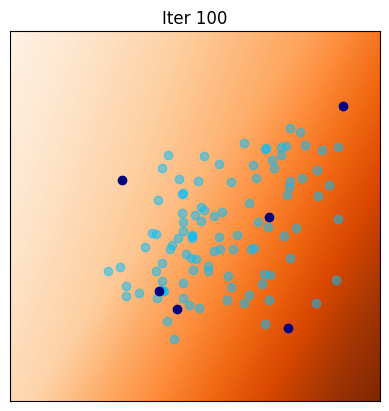

[200/2000], -1.369807


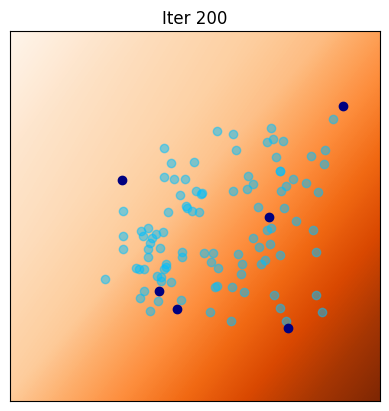

[300/2000], -1.349131


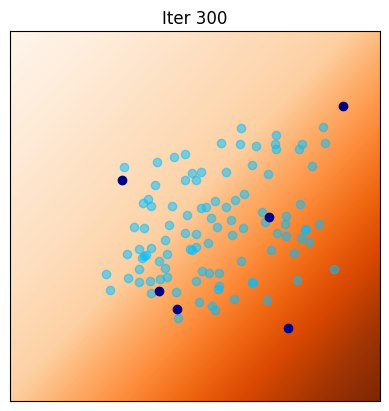

[400/2000], -1.353891


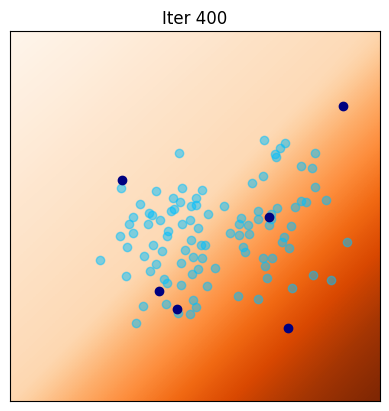

[500/2000], -1.309399


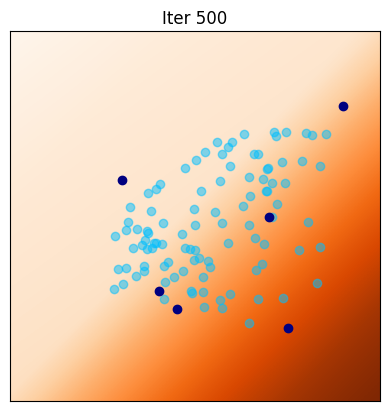

[600/2000], -1.338112


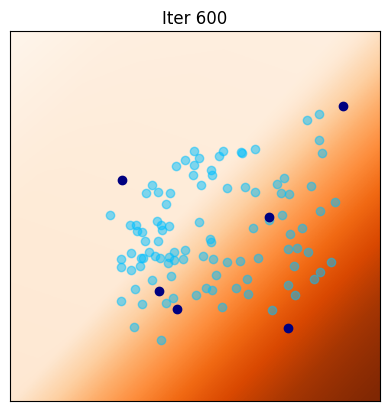

[700/2000], -1.298066


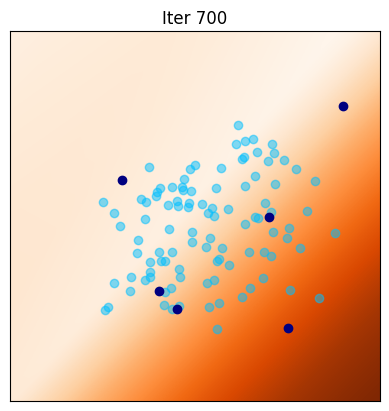

[800/2000], -1.326570


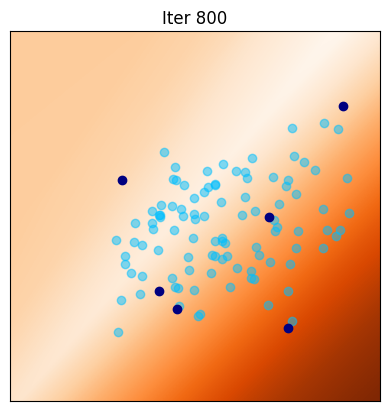

[900/2000], -1.239525


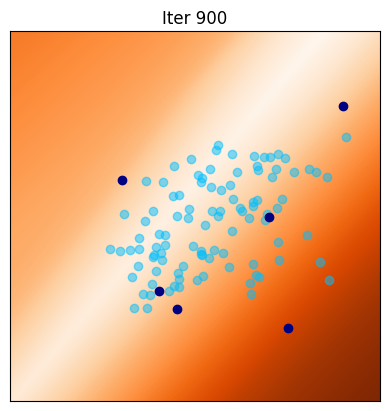

[1000/2000], -1.254252


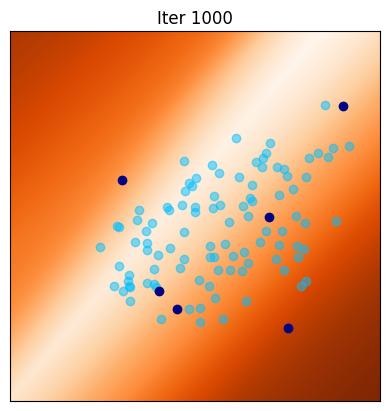

[1100/2000], -1.214335


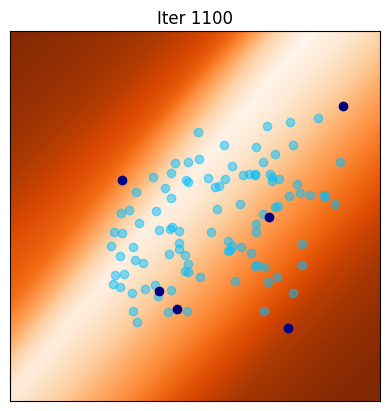

[1200/2000], -1.212350


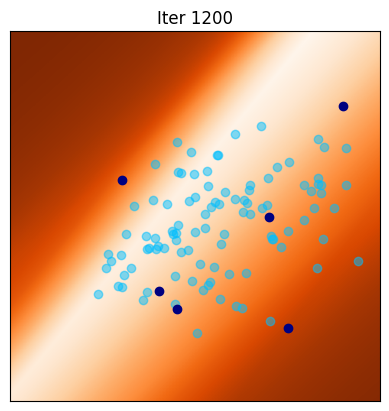

[1300/2000], -1.182042


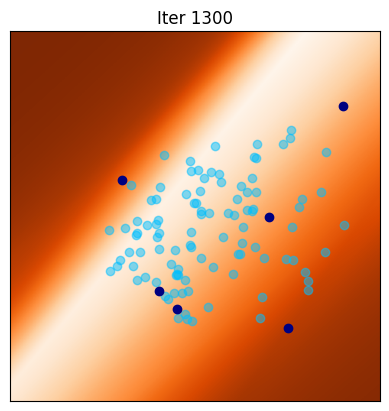

[1400/2000], -1.143920


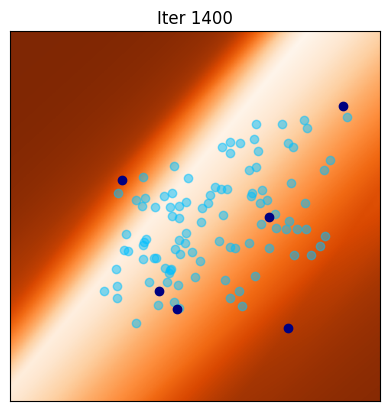

[1500/2000], -1.150467


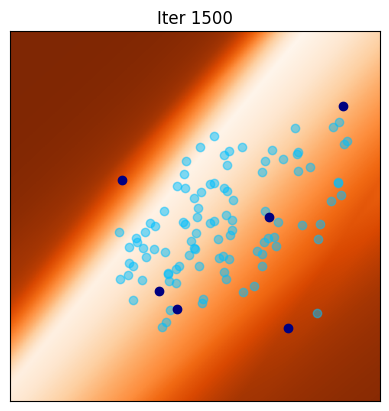

[1600/2000], -1.186040


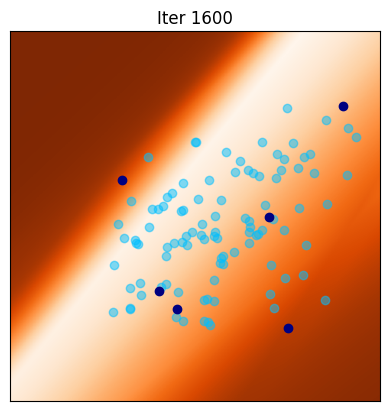

[1700/2000], -1.216493


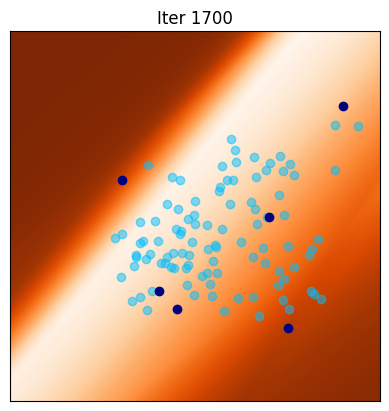

[1800/2000], -1.135817


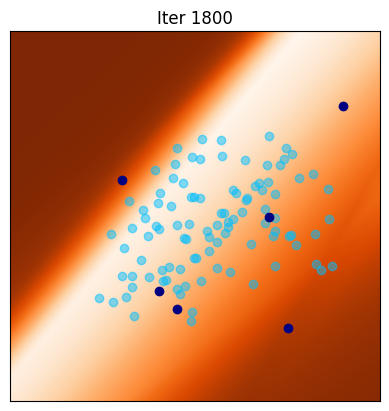

[1900/2000], -1.203073


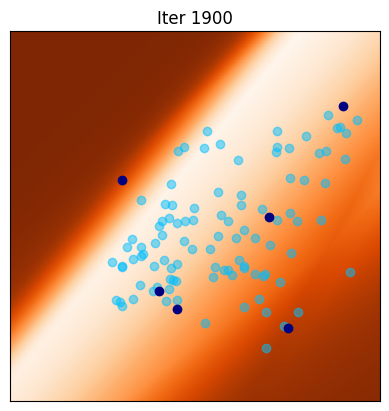

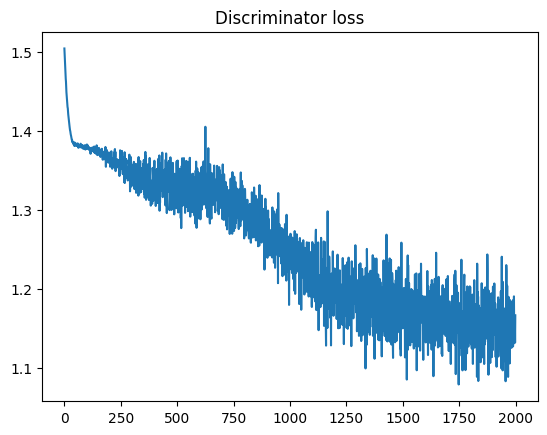

In [18]:
torch.manual_seed(1)  # initialize random seed for reproducibility

# parameters for discriminator optimization
lr = 0.002
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
niterD=2000

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, 0.999))

iter_display = 100  # display current configuration each iter_display iteration

Dlosses = []

for iter in range(0,niterD):

    ### UPDATE OF D ###
    ### ... ###

    optimD.zero_grad()
    D_y = sig(D(y))
    z = torch.randn((b,n_in)).to(device)
    x = G(z)
    D_g_y = sig(D(x))

    Dloss = -(torch.log(D_y).mean()+ torch.log(1-D_g_y).mean())

    Dloss.backward()
    optimD.step()

    ### SAVE LOSS ###
    Dlosst = -Dloss.item()
    Dlosses.append(-Dlosst)

    if(iter%iter_display == 0):
        print('[%d/%d], %f' % (iter, niterD, Dlosst))
        Dxgrid = sig(D(xgrid)).detach().cpu().numpy().reshape(nr,nc)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Iter '+str(iter)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()


### Plot the evolution of the discriminator loss ###
plt.figure(dpi=100)
plt.plot(Dlosses)
plt.title('Discriminator loss')
plt.show()

## Train both the Generator and Discriminator

[0/100] 	Loss_D: 1.3660	Loss_G: -0.0863


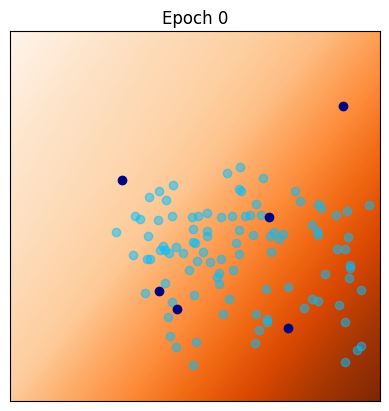

[1/100] 	Loss_D: 1.3670	Loss_G: -0.0182
[2/100] 	Loss_D: 1.3612	Loss_G: -0.0568
[3/100] 	Loss_D: 1.3397	Loss_G: -0.0128
[4/100] 	Loss_D: 1.3681	Loss_G: -0.0426
[5/100] 	Loss_D: 1.3470	Loss_G: -0.0023
[6/100] 	Loss_D: 1.1648	Loss_G: 0.1028
[7/100] 	Loss_D: 1.1596	Loss_G: 0.0678
[8/100] 	Loss_D: 1.2494	Loss_G: 0.0934
[9/100] 	Loss_D: 1.1110	Loss_G: -0.0974
[10/100] 	Loss_D: 1.1469	Loss_G: 0.2148


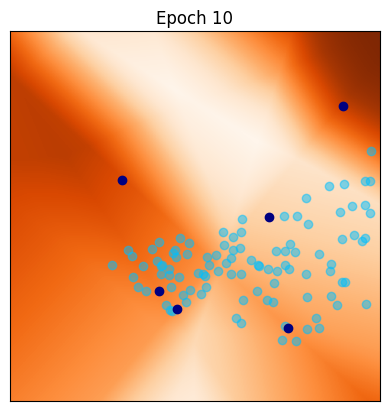

[11/100] 	Loss_D: 1.1747	Loss_G: 0.2850
[12/100] 	Loss_D: 1.1730	Loss_G: 0.2718
[13/100] 	Loss_D: 1.1610	Loss_G: -0.1222
[14/100] 	Loss_D: 1.2166	Loss_G: 0.1341
[15/100] 	Loss_D: 1.2554	Loss_G: 0.1132
[16/100] 	Loss_D: 1.2663	Loss_G: 0.1922
[17/100] 	Loss_D: 1.2107	Loss_G: 0.2550
[18/100] 	Loss_D: 1.1983	Loss_G: 0.1664
[19/100] 	Loss_D: 1.1841	Loss_G: 0.3041
[20/100] 	Loss_D: 1.0179	Loss_G: 0.1536


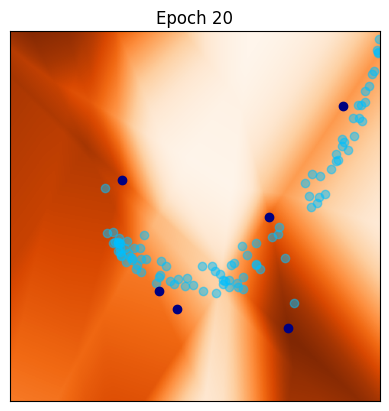

[21/100] 	Loss_D: 0.9224	Loss_G: 0.3715
[22/100] 	Loss_D: 0.8562	Loss_G: 0.6896
[23/100] 	Loss_D: 0.7139	Loss_G: 0.2141
[24/100] 	Loss_D: 0.7999	Loss_G: 0.3514
[25/100] 	Loss_D: 0.8067	Loss_G: 1.1973
[26/100] 	Loss_D: 0.7485	Loss_G: 0.6045
[27/100] 	Loss_D: 0.7511	Loss_G: 0.7304
[28/100] 	Loss_D: 0.7147	Loss_G: 0.9809
[29/100] 	Loss_D: 0.8866	Loss_G: 1.1926
[30/100] 	Loss_D: 0.7690	Loss_G: 0.8787


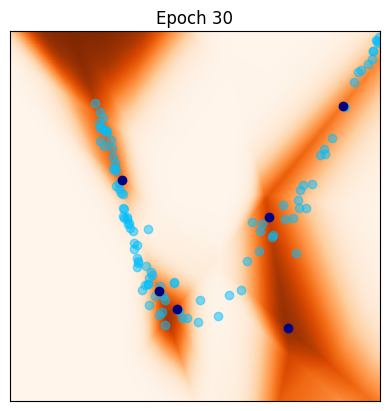

[31/100] 	Loss_D: 0.8673	Loss_G: 0.9926
[32/100] 	Loss_D: 0.8101	Loss_G: 1.0583
[33/100] 	Loss_D: 0.8544	Loss_G: 1.0135
[34/100] 	Loss_D: 0.9083	Loss_G: 0.9454
[35/100] 	Loss_D: 0.8493	Loss_G: 1.0430
[36/100] 	Loss_D: 0.8709	Loss_G: 0.7771
[37/100] 	Loss_D: 0.8599	Loss_G: 0.7227
[38/100] 	Loss_D: 0.9430	Loss_G: 0.9567
[39/100] 	Loss_D: 0.8468	Loss_G: 0.2592
[40/100] 	Loss_D: 0.8996	Loss_G: 0.9326


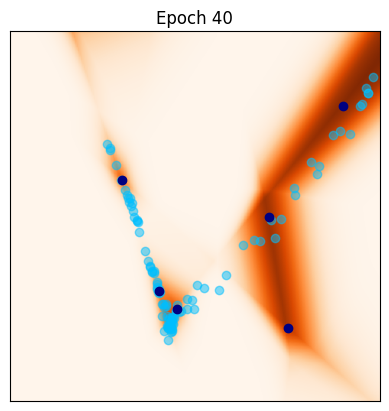

[41/100] 	Loss_D: 0.8899	Loss_G: 0.1168
[42/100] 	Loss_D: 0.8950	Loss_G: 0.9558
[43/100] 	Loss_D: 0.9025	Loss_G: 0.5770
[44/100] 	Loss_D: 0.9352	Loss_G: 0.7506
[45/100] 	Loss_D: 0.8962	Loss_G: 0.8207
[46/100] 	Loss_D: 0.9409	Loss_G: 0.7261
[47/100] 	Loss_D: 0.9600	Loss_G: 0.7053
[48/100] 	Loss_D: 0.9837	Loss_G: 1.0804
[49/100] 	Loss_D: 0.9339	Loss_G: 1.0625
[50/100] 	Loss_D: 0.9053	Loss_G: 0.8596


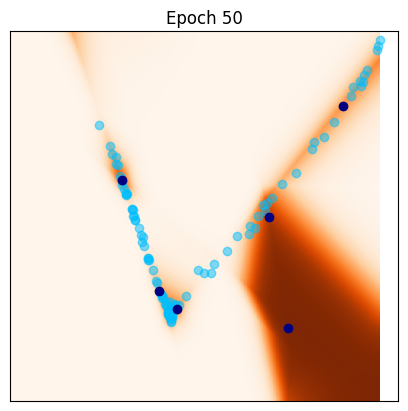

[51/100] 	Loss_D: 0.8903	Loss_G: 0.9081
[52/100] 	Loss_D: 0.9170	Loss_G: 0.8065
[53/100] 	Loss_D: 0.8932	Loss_G: 1.0909
[54/100] 	Loss_D: 0.9304	Loss_G: 1.0882
[55/100] 	Loss_D: 0.8396	Loss_G: 0.1336
[56/100] 	Loss_D: 0.7623	Loss_G: 0.2817
[57/100] 	Loss_D: 0.8906	Loss_G: 0.6681
[58/100] 	Loss_D: 0.8966	Loss_G: 1.3481
[59/100] 	Loss_D: 0.8473	Loss_G: 0.9967
[60/100] 	Loss_D: 0.8706	Loss_G: 0.7393


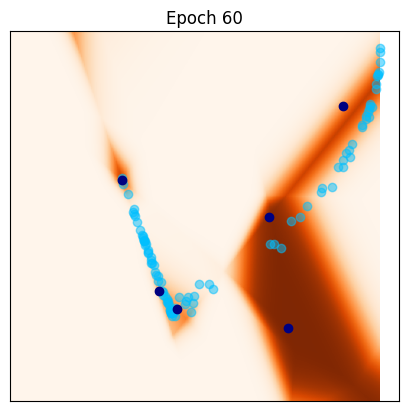

[61/100] 	Loss_D: 0.7216	Loss_G: 0.4896
[62/100] 	Loss_D: 0.8546	Loss_G: 1.1013
[63/100] 	Loss_D: 0.8562	Loss_G: 0.8920
[64/100] 	Loss_D: 0.8295	Loss_G: 0.6859
[65/100] 	Loss_D: 0.8340	Loss_G: 0.7999
[66/100] 	Loss_D: 0.8619	Loss_G: 0.8175
[67/100] 	Loss_D: 0.8409	Loss_G: 0.8550
[68/100] 	Loss_D: 0.8257	Loss_G: 1.0866
[69/100] 	Loss_D: 0.8440	Loss_G: 1.3133
[70/100] 	Loss_D: 0.8082	Loss_G: 1.0402


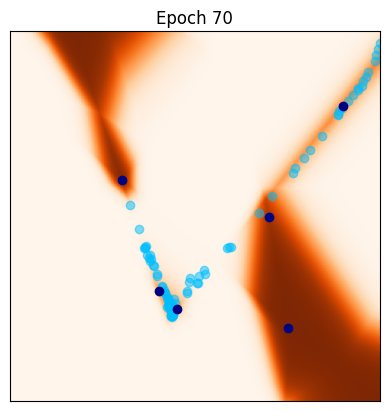

[71/100] 	Loss_D: 0.8339	Loss_G: 0.8402
[72/100] 	Loss_D: 0.8227	Loss_G: 1.0094
[73/100] 	Loss_D: 0.8302	Loss_G: 0.8222
[74/100] 	Loss_D: 0.8713	Loss_G: 1.5320
[75/100] 	Loss_D: 0.8479	Loss_G: 1.2322
[76/100] 	Loss_D: 0.8263	Loss_G: 0.8831
[77/100] 	Loss_D: 0.8013	Loss_G: 0.8882
[78/100] 	Loss_D: 0.8317	Loss_G: 0.7990
[79/100] 	Loss_D: 0.8400	Loss_G: 1.1133
[80/100] 	Loss_D: 0.8306	Loss_G: 0.9791


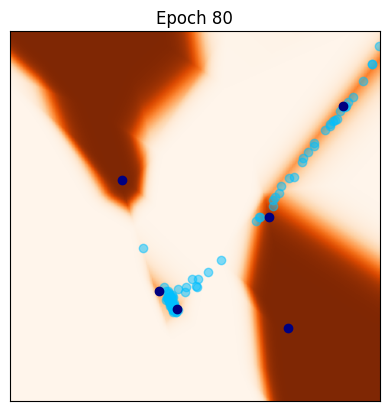

[81/100] 	Loss_D: 0.8700	Loss_G: 1.5455
[82/100] 	Loss_D: 0.8966	Loss_G: 1.2306
[83/100] 	Loss_D: 0.8488	Loss_G: 0.9805
[84/100] 	Loss_D: 0.8383	Loss_G: 0.5568
[85/100] 	Loss_D: 0.8551	Loss_G: 1.0178
[86/100] 	Loss_D: 0.8964	Loss_G: 1.1397
[87/100] 	Loss_D: 0.8496	Loss_G: 0.6753
[88/100] 	Loss_D: 0.7804	Loss_G: 0.7089
[89/100] 	Loss_D: 0.6739	Loss_G: 0.2714
[90/100] 	Loss_D: 0.6654	Loss_G: 0.1976


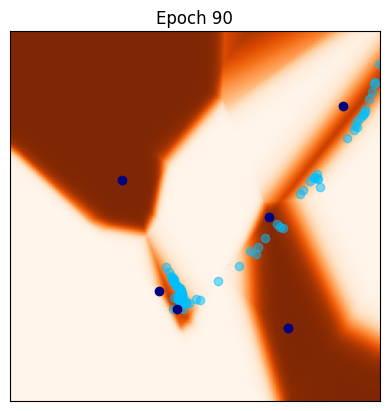

[91/100] 	Loss_D: 0.4370	Loss_G: 0.6141
[92/100] 	Loss_D: 0.4859	Loss_G: 0.2886
[93/100] 	Loss_D: 0.5064	Loss_G: 0.3802
[94/100] 	Loss_D: 0.4568	Loss_G: 0.4127
[95/100] 	Loss_D: 0.4090	Loss_G: -0.6659
[96/100] 	Loss_D: 0.4819	Loss_G: 0.2821
[97/100] 	Loss_D: 0.4555	Loss_G: -0.3917
[98/100] 	Loss_D: 0.5199	Loss_G: -0.7139
[99/100] 	Loss_D: 0.4789	Loss_G: 0.7868


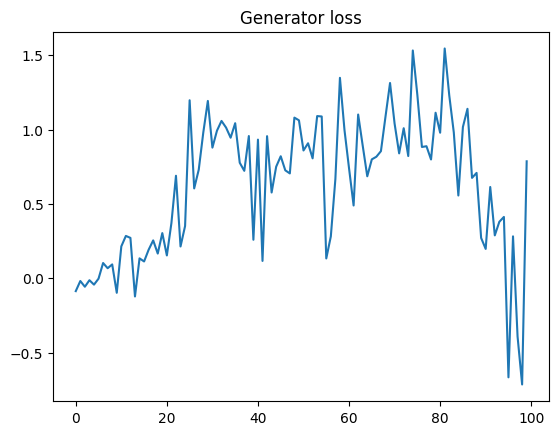

In [20]:
lr = 0.002   # learning rate for generator
lrdisc = 0.002   # learning rate for generator

## parameters for training
n_epochs = 100
niterD=200
niterG=10

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

Glosses = []
Dlosses = []

iter_display = 10

# Main loop
for epoch in range(n_epochs):

    ############################
    ### Train discriminator (niterD iterations)
    ############################
    for iter in range(0,niterD):

      optimD.zero_grad()
      D_y = sig(D(y))
      z = torch.randn((b,n_in)).to(device)
      x = G(z)
      D_g_y = sig(D(x))
      Dloss = -(torch.log(D_y).mean()+ torch.log(1-D_g_y).mean())
      Dloss.backward()
      optimD.step()

    ############################
    ### Train generator (niterG iterations)
    ############################
    for iter in range(0,niterG):
        ### ... ###
        optimG.zero_grad()
        z = torch.randn((b,n_in)).to(device)
        x = G(z)
        D_g_y = D(x)
        Gloss = -D_g_y.mean(axis=0)
        Gloss.backward()
        optimG.step()
        ### ... ###

    # Output training stats
    print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f'
      % (epoch, n_epochs, Dloss.item(), Gloss.item()))
    Glosses.append(Gloss.item())
    Dlosses.append(-Dloss.item())


    if(epoch % iter_display == 0):
        Dxgrid = sig(D(xgrid)).detach().cpu().numpy().reshape(nr,nc)
        z = torch.randn(b, 1, n_in, device=device)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Epoch '+str(epoch)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()

# Save final generator for later use
gan = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
gan.load_state_dict(G.state_dict())

### Plot the evolution of the discriminator loss ###
plt.figure(dpi=100)
plt.plot(Glosses)
plt.title('Generator loss')
plt.show()